In [1]:
import json
import shelve
from tqdm import tqdm
import random
import csv

import matplotlib.pyplot as plt

from data.ag.action_genome import AG, AGViewer
from util.graph_utils import check_edge_exists

root = '/data/Datasets/ag/'
subset_file = 'data/ag/subset_shelve'
#ag = AG(root, split=None, subset_file=None, verb_blacklist=['smile', 'laugh', 'sneeze']) #view the full dataset
#ag = AG(root, split='test', subset_file='data/ag/subset_shelve') #view the test split dataset
#ag = AG(root, split='train', subset_file='data/ag/subset_shelve') #view the test split dataset


In [6]:
for a, (v, o) in sorted(ag.action_verb_obj_map.items(), key=lambda x: x[1][0]):
    action = ag.action_classes[a]
    verb = ag.verb_classes[v]
    obj = None if o is None else ag.object_classes[o]
    print(action, f'({verb}, {obj})')

Taking/consuming some medicine (awaken, bed)
Closing a refrigerator (awaken, None)
Closing a door (close, door)
Closing a book (close, book)
Washing something with a towel (close, box)
Throwing a box somewhere (close, laptop)
Taking a picture of something (close, window)
Putting a cup/glass/bottle somewhere (close, closet/cabinet)
Taking a vacuum from somewhere (close, refrigerator)
Opening a refrigerator (cook, food)
Putting shoes somewhere (dress, shoe)
Fixing their hair (dress, clothes)
Fixing a light (drink, cup/glass/bottle)
Throwing food somewhere (eat, sandwich)
Throwing something on the floor (eat, medicine)
Someone is laughing (eat, food)
Fixing a door (fix, door)
Taking a broom from somewhere (fix, light)
Watching television (fix, vacuum)
Fixing a vacuum (fix, doorknob)
Fixing a doorknob (fix, None)
Holding a vacuum (grasp, doorknob)
Holding some clothes (hold, clothes)
Holding a phone/camera (hold, phone/camera)
Holding a bag (hold, bag)
Holding a book (hold, book)
Watching/

INDEX: 15
LABEL: False
ACTION: Holding a bag
VERB-OBJ: hold bag
VIDEO-FRAME-ACTION ID: 7HVU8.mp4/000016.png_20
[('person', 'looking_at', 'floor'), ('floor', 'beneath', 'person'), ('person', 'standing_on', 'floor'), ('person', 'not_looking_at', 'bag'), ('bag', 'in_front_of', 'person'), ('bag', 'on_the_side_of', 'person'), ('person', 'holding', 'bag')]


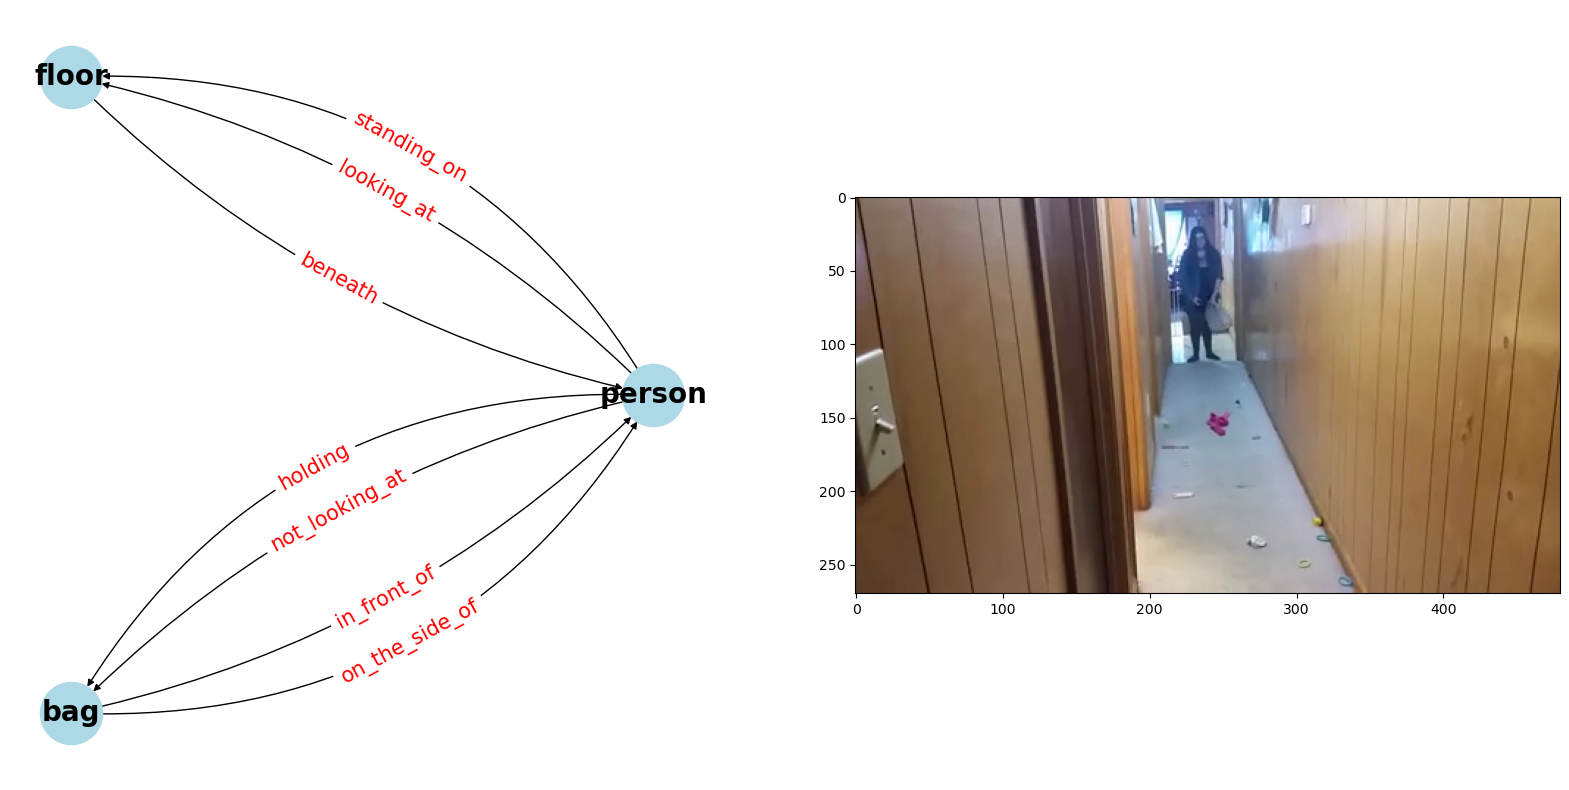

In [19]:
%autoreload

with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict)
    agview.view(0)
    while True:
        answer = input(f"{agview.message}current search key : {str(agview.key)}")
        new_idx = agview.process_command(answer)
        if new_idx is not None:
            agview.view(new_idx)
        else:
            break


INDEX: 18653
[('person', 'looking_at', 'window'), ('window', 'in_front_of', 'person'), ('person', 'not_contacting', 'window'), ('person', 'looking_at', 'closet/cabinet'), ('closet/cabinet', 'in_front_of', 'person'), ('person', 'not_contacting', 'closet/cabinet')]


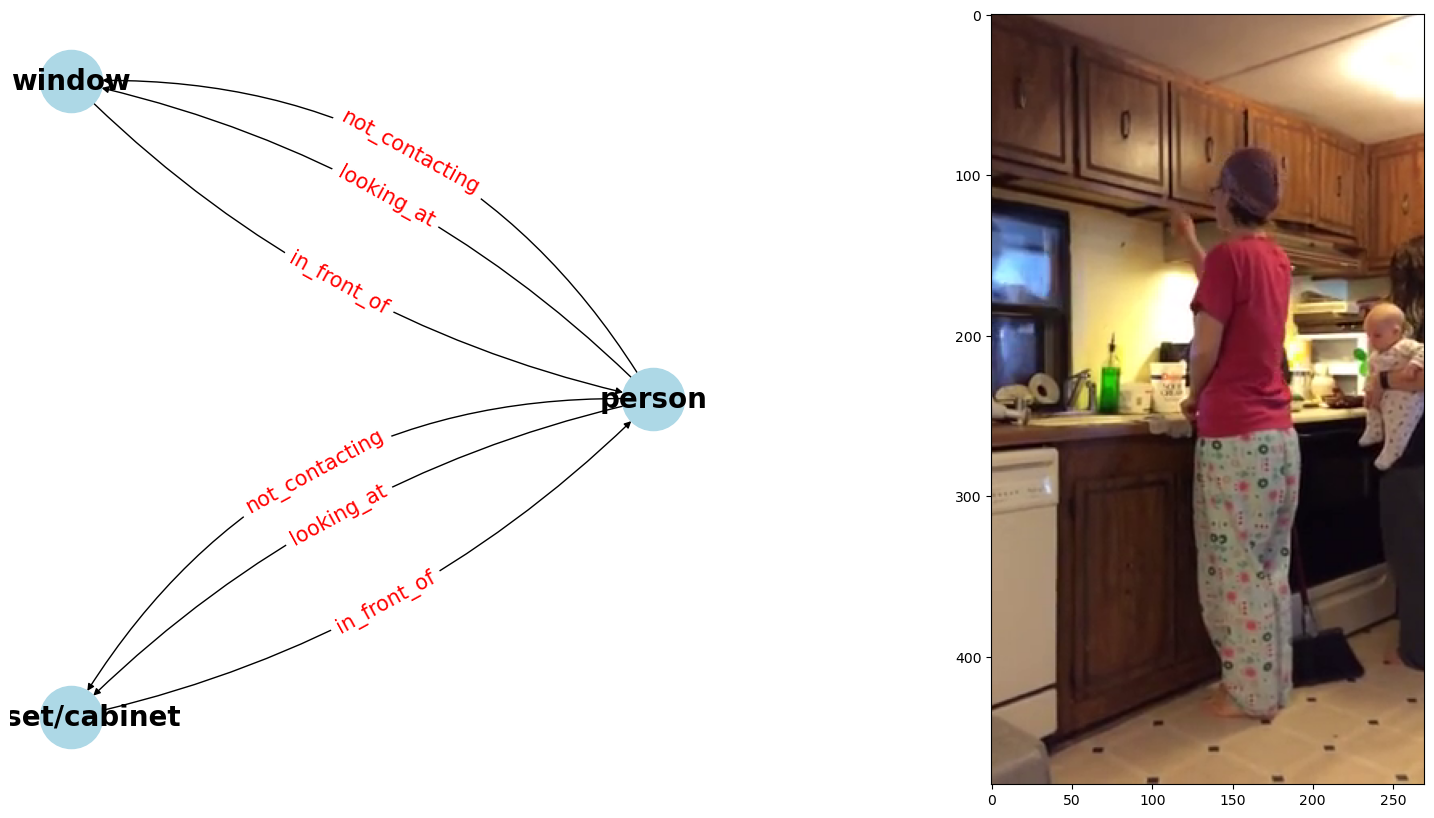

In [11]:
%autoreload
idx_list = list(range(len(ag)))
random.shuffle(idx_list)

correct_count = 0
incorrect_count = 0
with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict, human_test=True)
    for idx in idx_list:
        _, verb = agview.view(idx)
        if correct_count + incorrect_count > 0:
            accuracy = correct_count / (correct_count + incorrect_count)
        else:
            accuracy = 0
        answer = input(f"correct: {correct_count}, incorrect: {incorrect_count}, accuracy: {accuracy}")
        if answer == 'q':
            break
        if answer == verb:
            correct_count += 1
            print('CORRECT' + verb)
        else:
            incorrect_count += 1
            print('INCORRECT' + verb)


In [21]:
#Check for overlap between train, val, and test splits
with open('data/ag/split_train_val_test.json', 'r') as f:
    split_dict = json.load(f)
    train_ids = set(split_dict['train'])
    val_ids = set(split_dict['val'])
    test_ids = set(split_dict['test'])
    
    # Check for overlap
    train_val_overlap = train_ids.intersection(val_ids)
    train_test_overlap = train_ids.intersection(test_ids)
    val_test_overlap = val_ids.intersection(test_ids)

    if len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0:
        print(f"Warning: Found overlapping IDs between train and val splits")
    else:
        print("No overlap found between train and test splits")


No overlap found between train and test splits


In [2]:

VERBS = [
    "awaken",
    "close",
    "cook", 
    "dress",
    "drink",
    "eat",
    "fix",
    "grasp", 
    "hold",
    #"laugh",
    "lie",
    "make",
    "open",
    "photograph",
    "play",
    "pour",
    "put",
    "run",
    "sit",
    #"smile",
    #"sneeze",
    "snuggle",
    "stand",
    "take",
    "talk",
    "throw",
    "tidy",
    "turn",
    "undress",
    "walk",
    "wash",
    "watch",
    "work"
]

train_ag = AG(root, no_img=True, split='train', subset_file=subset_file, verb_whitelist=VERBS)
print(train_ag.verb_classes)
print(train_ag.action_classes)
print(train_ag.action_verb_obj_map)

split: train | length: 4791
['awaken', 'close', 'cook', 'dress', 'drink', 'eat', 'fix', 'grasp', 'hold', 'lie', 'make', 'open', 'photograph', 'play', 'pour', 'put', 'run', 'sit', 'snuggle', 'stand', 'take', 'talk', 'throw', 'tidy', 'turn', 'undress', 'walk', 'wash', 'watch', 'work']
['Holding some clothes', 'Putting clothes somewhere', 'Taking some clothes from somewhere', 'Throwing clothes somewhere', 'Tidying some clothes', 'Washing some clothes', 'Closing a door', 'Fixing a door', 'Opening a door', 'Putting something on a table', 'Sitting on a table', 'Sitting at a table', 'Tidying up a table', 'Washing a table', 'Working at a table', 'Holding a phone/camera', 'Playing with a phone/camera', 'Putting a phone/camera somewhere', 'Taking a phone/camera from somewhere', 'Talking on a phone/camera', 'Holding a bag', 'Opening a bag', 'Putting a bag somewhere', 'Taking a bag from somewhere', 'Throwing a bag somewhere', 'Closing a book', 'Holding a book', 'Opening a book', 'Putting a book so